In [2]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../scripts')
from PreparaDataset import *

In [5]:
data = pd.read_csv('../../data/NFL.csv')

In [12]:
dataframe = prepara_df(data)

dataframe.loc[((dataframe['Odds_H'] < dataframe['Odds_A']) & (dataframe['Back_Home'] == 1)), 'Back_Favorito'] = 1
dataframe.loc[((dataframe['Odds_H'] < dataframe['Odds_A']) & (dataframe['Back_Home'] == 0)), 'Back_Favorito'] = 0
dataframe.loc[((dataframe['Odds_H'] > dataframe['Odds_A']) & (dataframe['Back_Away'] == 1)), 'Back_Favorito'] = 1
dataframe.loc[((dataframe['Odds_H'] > dataframe['Odds_A']) & (dataframe['Back_Away'] == 0)), 'Back_Favorito'] = 0

dataframe.loc[(dataframe['Odds_H'] <= dataframe['Odds_A']), 'odds'] = dataframe['Odds_H']
dataframe.loc[(dataframe['Odds_H'] > dataframe['Odds_A']), 'odds'] = dataframe['Odds_A']

# dataframe = dataframe[(dataframe['odds'] > 1.4)]

dataframe.dropna(inplace=True)
dataframe.reset_index(drop=True, inplace=True)

c:\Users\johnn\Documents\venvs\nfl_models\ML\back_fav\../../scripts\PreparaDataset.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.loc[(_df['Home_Pts'] > _df['Away_Pts']), 'Back_Home'] = 1
c:\Users\johnn\Documents\venvs\nfl_models\ML\back_fav\../../scripts\PreparaDataset.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.loc[(_df['Home_Pts'] < _df['Away_Pts']), 'Back_Away'] = 1
c:\Users\johnn\Documents\venvs\nfl_models\ML\back_fav\../../scripts\PreparaDataset.py:56: SettingWithCopyWarning: 
A

In [13]:
print(f'Odd média: {dataframe.odds.mean():.2f} ({1 / (dataframe.odds.mean()):.2f}) | Média Back Home: {dataframe.Back_Favorito.mean():.2f}')
print(f'Tamanho da amostra: {dataframe.shape[0]}')

Odd média: 1.46 (0.69) | Média Back Home: 0.66
Tamanho da amostra: 491


In [4]:
div = len(dataframe)
div = 150
treino = dataframe.iloc[:div, :]
val = dataframe.iloc[div: , :]

print(f'Treino: {treino.shape[0]} | Validação: {val.shape[0]}')

Treino: 150 | Validação: 336


In [167]:
features = ['CV_Over', 'CV_ML', 'Acima_Last_CG_A', 'P(U)', 'Avg_CG_H']

In [168]:
from pycaret.classification import *

cls = setup(data = dataframe,
            ignore_features = [x for x in dataframe.columns.to_list() if x not in features and x != 'Back_Favorito'],
            target = 'Back_Favorito',
            train_size = 0.4,
            normalize = True,
            normalize_method = 'zscore',
            session_id = 2023,
            verbose = False
            )

xtrain_treino = get_config('X_train')
ytrain_treino = get_config('y_train')
xtrain_teste = get_config('X_test')
ytrain_teste = get_config('y_test')

real_treino = pd.concat([xtrain_treino, ytrain_treino], axis=1)
real_teste = pd.concat([xtrain_teste, ytrain_teste],  axis=1)

In [ ]:
model = compare_models(sort = 'precision', cross_validation = False, include = ['lr', 'dt', 'et', 'knn', 'ridge', 'rf', 'rbfsvm', 'nb'])

In [169]:
model = create_model('lr', fold=5, return_train_score=True)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [242]:
def info_modelo(modelo, data=None):
    if data is None:
        pred = predict_model(modelo, verbose = False)
    else:
        pred = predict_model(modelo, data, verbose = False)

    pred = pred.merge(dataframe['odds'], left_index=True, right_index=True, how='left')
    if 'odds_x' in pred.columns.tolist():
        pred.rename(columns={'odds_x': 'odds'}, inplace=True)
        pred.drop(columns='odds_y', inplace=True)
    
    stake = 1

    total = pred.shape[0]

    # Filtro 1
    # pred = pred[(pred['CV_ML'] >= 0.4) | (pred['CV_ML'] <= 0.2)]
    # pred = pred[(pred['prediction_score'] >= 0.7)]
    # pred = pred[(pred['Avg_CG_H'] >= 60) | (pred['Avg_CG_H'] < 50)]

    # Filtro 2
    # pred = pred[(pred['CV_ML'] >= 0.6)]
    # pred = pred[(pred['prediction_score'] >= 0.7)]
    # pred = pred[(pred['Avg_CG_H'] >= 60) | (pred['Avg_CG_H'] < 50)]
    
    # Filtro 3
    pred = pred[(pred['CV_ML'] >= 0.6)]
    pred = pred[(pred['prediction_score'] >= 0.7)]
    pred = pred[(pred['Avg_CG_H'] >= 60) | (pred['Avg_CG_H'] < 50)]
    pred = pred[(pred['odds'] >= 1.15)]

    pred.loc[(pred['Back_Favorito'] == 0), 'PL_BF_Predictions'] = - stake
    pred.loc[(pred['Back_Favorito'] == 1), 'PL_BF_Predictions'] = ((pred['odds']) - 1) * stake
    
    reserva = pred.copy()
    pred = pred[(pred['prediction_label'] == 1)]

    plb = pred['PL_BF_Predictions'].sum()
    entradas = pred[pred['prediction_label'] == 1].shape[0]
    wr = round((pred[pred['Back_Favorito'] == 1].shape[0] / entradas), 2)
    oddback = pred['odds'].mean()
    med_gain = pred[pred['Back_Favorito'] == 1]['PL_BF_Predictions'].mean()
    med_loss = pred[pred['Back_Favorito'] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)
    print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
    print(f'Odd média: {oddback:.2f}')
    print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
    print(f'EM: {ev:.2f}')
    print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')

    pred.reset_index(drop=True, inplace=True)
    pred.sort_index(inplace=True)
    pred['hbacu'] = pred['PL_BF_Predictions'].cumsum()
    pred = pred[pred['prediction_label'] == 1]

    pred['hbacu'].plot.line(figsize=(6,2))

    return pred

In [ ]:
# tuned = tune_model(model, fold=5, optimize='precision', return_train_score=True, search_library='optuna', search_algorithm='tpe', n_iter=20)

# Modelo base

PL: 3.98 | ROI: 12.84% | Prec.: 0.90
Odd média: 1.25
Média Gain: 0.25 | Média Loss: -1.00
EM: 0.12
31 entradas em 196 jogos (15.82%)


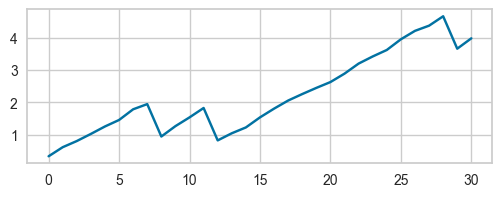

In [211]:
df_treino = info_modelo(model, real_treino)

PL: 2.97 | ROI: 6.60% | Prec.: 0.87
Odd média: 1.23
Média Gain: 0.23 | Média Loss: -1.00
EM: 0.07
45 entradas em 295 jogos (15.25%)


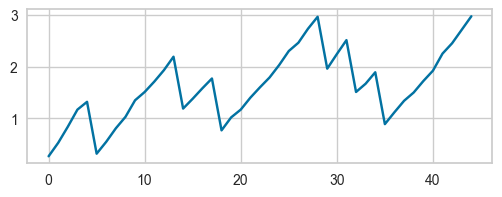

In [233]:
df_teste = info_modelo(model, real_teste)

PL: 6.95 | ROI: 9.14% | Prec.: 0.88
Odd média: 1.24
Média Gain: 0.24 | Média Loss: -1.00
EM: 0.09
76 entradas em 491 jogos (15.48%)


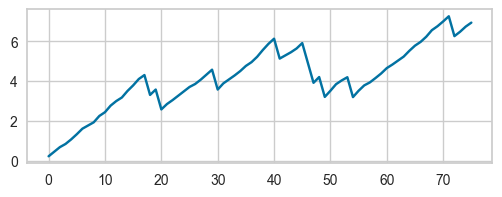

In [214]:
df_comp = info_modelo(model, dataframe)

# Ensembled

In [181]:
ensembled2 = ensemble_model(model, fold=5, return_train_score=True, n_estimators=20, optimize='precision')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [202]:
ensembled2

BaggingClassifier(base_estimator='deprecated', bootstrap=True,
                  bootstrap_features=False,
                  estimator=LogisticRegression(C=1.0, class_weight=None,
                                               dual=False, fit_intercept=True,
                                               intercept_scaling=1,
                                               l1_ratio=None, max_iter=1000,
                                               multi_class='auto', n_jobs=None,
                                               penalty='l2', random_state=2023,
                                               solver='lbfgs', tol=0.0001,
                                               verbose=0, warm_start=False),
                  max_features=1.0, max_samples=1.0, n_estimators=20,
                  n_jobs=None, oob_score=False, random_state=2023, verbose=0,
                  warm_start=False)

PL: 4.20 | ROI: 13.12% | Prec.: 0.91
Odd média: 1.25
Média Gain: 0.25 | Média Loss: -1.00
EM: 0.14
32 entradas em 196 jogos (16.33%)


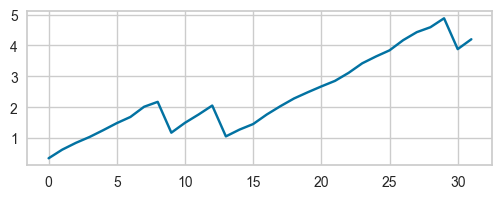

In [228]:
df_treino = info_modelo(ensembled2, real_treino)

PL: 3.73 | ROI: 7.77% | Prec.: 0.88
Odd média: 1.23
Média Gain: 0.23 | Média Loss: -1.00
EM: 0.08
48 entradas em 295 jogos (16.27%)


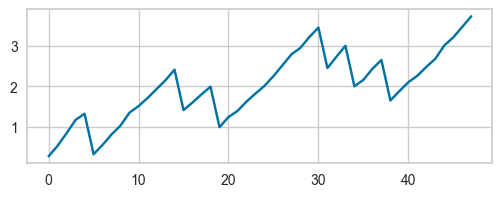

In [243]:
df_teste = info_modelo(ensembled2, real_teste)

PL: 7.93 | ROI: 9.91% | Prec.: 0.89
Odd média: 1.24
Média Gain: 0.24 | Média Loss: -1.00
EM: 0.10
80 entradas em 491 jogos (16.29%)


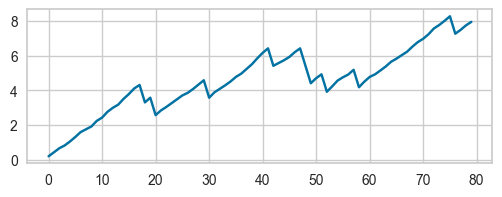

In [230]:
df_comp = info_modelo(ensembled2, dataframe)

In [245]:
df_teste.to_excel('teste.xlsx', index=True)

In [246]:
save_model(ensembled2, 'back_fav_ens2')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\johnn\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['P(U)', 'Avg_CG_H',
                                              'Acima_Last_CG_A', 'CV_ML',
                                              'CV_Over'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprec...
                                                           

# Script variáveis

In [22]:
colunas = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under',
       'HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff',
       'Porc_Over_Home', 'Porc_Over_Away','Avg_CG_H', 'DP_CG_H', 'CV_CG_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A',
       'Last_CG_H', 'Last_CG_A', 'Acima_Last_CG_H', 'Acima_Last_CG_A',
       'Abaixo_Last_CG_H', 'Abaixo_Last_CG_A', 'CV_ML', 'CV_Over']

In [23]:
import random

def pegar_elementos_aleatorios(lista):
    # Gerar um número aleatório entre 2 e 7
    num_elementos = random.randint(2, 13)

    # Garantir que o número de elementos não ultrapasse o tamanho da lista
    num_elementos = min(num_elementos, len(lista))

    # Selecionar elementos aleatórios da lista
    elementos_aleatorios = random.sample(lista, num_elementos)

    return elementos_aleatorios

In [28]:
melhor_PL = -10000

for i in range(30):
    features = pegar_elementos_aleatorios(colunas)

    cls = setup(data = dataframe,
            ignore_features = [x for x in dataframe.columns.to_list() if x not in features and x != 'Back_Favorito'],
            target = 'Back_Favorito',
            train_size = 0.5,
            normalize = True,
            normalize_method = 'zscore',
            session_id = 2023,
            verbose = False
            )
    
    model = create_model('lr', verbose = False, fold = 5)
    tab = pull()
    prec_model = (tab.loc['Mean', 'Prec.'])
    dp_model = (tab.loc['Std', 'Prec.'])
    pred = predict_model(model, verbose = False)
    stake = 1

    pred = pred.merge(dataframe['odds'], left_index=True, right_index=True, how='left')
    if 'odds_x' in pred.columns.tolist():
        pred.rename(columns={'odds_x': 'odds'}, inplace=True)
        pred.drop(columns='odds_y', inplace=True)

    total = pred.shape[0]

    pred.loc[(pred['Back_Favorito'] == 0), 'PL_BF_Predictions'] = - stake
    pred.loc[(pred['Back_Favorito'] == 1), 'PL_BF_Predictions'] = ((pred['odds']) - 1) * stake
    
    reserva = pred.copy()
    pred = pred[(pred['prediction_label'] == 1)]

    plb = pred['PL_BF_Predictions'].sum()
    entradas = pred[pred['prediction_label'] == 1].shape[0]
    wr = round((pred[pred['Back_Favorito'] == 1].shape[0] / entradas), 2)
    oddback = pred['odds'].mean()
    med_gain = pred[pred['Back_Favorito'] == 1]['PL_BF_Predictions'].mean()
    med_loss = pred[pred['Back_Favorito'] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

    if prec_model > melhor_PL:
        best_model = model
        melhor_PL = prec_model
        print(f'**Novo melhor** PL: {plb:.2f} | EM: {ev:.2f} | Prec.: {prec_model:.4f} | Std: {dp_model:.4f}')
        print(f'Features: {features}\n')

**Novo melhor** PL: -17.91 | EM: -0.07 | Prec.: 0.6569 | Std: 0.0122
Features: ['P(A)', 'Last_CG_H', 'HA_Odds_A', 'Odds_Over', 'DP_CG_H', 'CV_CG_H']

**Novo melhor** PL: -17.71 | EM: -0.07 | Prec.: 0.6598 | Std: 0.0115
Features: ['Porc_Over_Home', 'Abaixo_Last_CG_H', 'Avg_CG_A', 'P(U)']

**Novo melhor** PL: -16.29 | EM: -0.07 | Prec.: 0.6772 | Std: 0.0176
Features: ['CV_ML', 'HA_Odds_H', 'Avg_CG_A', 'Odds_A']

**Novo melhor** PL: -19.45 | EM: -0.08 | Prec.: 0.6796 | Std: 0.0223
Features: ['Odds_Over', 'P_Diff', 'CV_CG_A', 'Acima_Last_CG_A', 'Abaixo_Last_CG_H', 'CV_Over']

**Novo melhor** PL: -13.62 | EM: -0.06 | Prec.: 0.6991 | Std: 0.0365
Features: ['Odds_Under', 'CV_Over', 'CV_ML', 'Acima_Last_CG_A', 'P(U)', 'Abaixo_Last_CG_H', 'Avg_CG_H']

